In [1]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import torchvision.transforms as T
import kornia.augmentation as K
import torch.nn.functional as F
from einops import rearrange
import torch
from torch.utils.data import DataLoader
from torchgeo.datamodules.utils import dataset_split
from torchgeo.datasets import DFC2022
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datamodule import DFC2022Dataloader
import evaluate
from PIL import Image
from tqdm.auto import tqdm
metric = evaluate.load("mean_iou")

In [3]:
cmap = ListedColormap(DFC2022.colormap)
preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                         reduce_labels=False,
                                         do_resize=False,
                                         do_rescale=False,
                                         do_normalize=False,)
train_dataset, test_dataset = DFC2022Dataloader(preprocessor).get_dataset()
train_dataloader, test_dataloader = DFC2022Dataloader(preprocessor).get_dataloader(batch_size=4)
val_dataset, _ = DFC2022Dataloader(preprocessor, 'val').get_dataset()

model = torch.load("Mask2_A_tiny_120.pt", map_location="cpu")

if isinstance(model, torch.nn.DataParallel):
    model = model.module
    print("Loaded from dataparallel module.")
if isinstance(model, dict):
    temp_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",)
    temp_model = torch.nn.DataParallel(temp_model)
    temp_model.load_state_dict(model)
    model = temp_model.module
    print("Loaded from dict.")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic")
# model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('Mask2_A_base_20.pt', map_location="cpu"))
# model = torch.load('Mask2_A_base_20.pt', map_location="cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
model = model.to(device)
print(type(model))

<class 'transformers.models.mask2former.modeling_mask2former.Mask2FormerForUniversalSegmentation'>


In [4]:
data = test_dataset[torch.randint(0, len(test_dataset), (1,))]
img = data[0]
mask = data[2]
model.eval()
with torch.no_grad():
    output = model(pixel_values=(img).to(device).unsqueeze(0))#T.Resize((100, 100))
mask_pred = preprocessor.post_process_semantic_segmentation(output,
                                                            target_sizes=[[512, 512]])

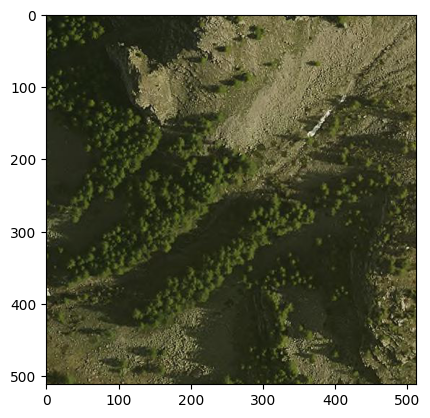

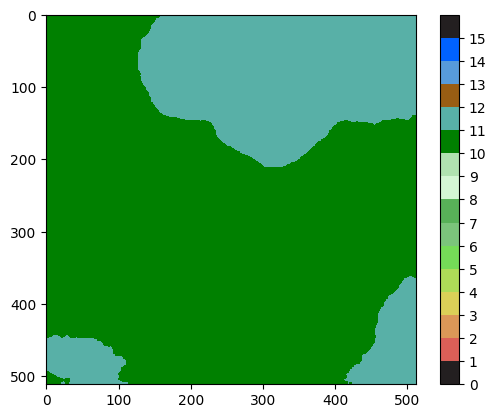

In [5]:
plt.imshow(img[:3].permute(1, 2, 0))
plt.show()

cax = plt.imshow(mask_pred[0].to('cpu'), cmap, vmin=0, vmax=16)
cbar = plt.colorbar(cax, ticks = range(len(DFC2022.colormap)))
plt.show()


In [7]:
model.eval()

for i, batch in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        outputs = model(pixel_values=batch["pixel_values"].to(device),)
    target_sizes = [[512, 512] for i in batch["pixel_values"]]
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                    target_sizes = target_sizes)
    metric.add_batch(references=batch["original_segmentations"], predictions=predicted_segmentation_maps)

print("Test MIoU: ", metric.compute(num_labels = 15, ignore_index = 0)['mean_iou'])

  0%|          | 0/20 [00:00<?, ?it/s]

Test MIoU:  0.3859828592365675


In [ ]:
img1 = Image.open('IMG_PNEO3_202401.TIF')
img2 = Image.open('IMG_PNEO4_202302.TIF')

# img1 = Image.open('IMG_PHR1B_20220308.TIF')
# img2 = Image.open('IMG_PHR1B_20220618.TIF')
scale_factor = 0.3 / 0.5
new_width = int(img1.width * scale_factor)
new_height = int(img1.height * scale_factor)

# Resize the image using PyTorch
resize_transform = T.Compose([
    T.Resize((new_height, new_width)),
    T.ToTensor()
])

In [ ]:
tensor_image0 = resize_transform(img1)
tensor_image1 = resize_transform(img2)
# image0_03m = T.ToTensor()(img1)
# image1_03m = T.ToTensor()(img2)

In [ ]:
sample = K.AugmentationSequential(
                    K.RandomCrop((512, 512), p=1, keepdim=False),
                    data_keys=['input', 'mask'],
                )(tensor_image0[:3].unsqueeze(0), tensor_image1[:3].unsqueeze(0))

# sample = K.AugmentationSequential(
#                     K.RandomCrop((512, 512), p=1, keepdim=False),
#                     data_keys=['input', 'mask'],
#                 )(image0_03m[:3].unsqueeze(0), image1_03m[:3].unsqueeze(0))

sample[0] = rearrange(sample[0], '() c h w -> c h w')
sample[1] = rearrange(sample[1], '() c h w -> c h w')

model.eval()
with torch.no_grad():
    output0 = model(pixel_values=sample[0].to(device).unsqueeze(0))
    output1 = model(pixel_values=sample[1].to(device).unsqueeze(0))
mask_pred0 = preprocessor.post_process_semantic_segmentation(output0,
                                                            target_sizes=[[512, 512]])
mask_pred1 = preprocessor.post_process_semantic_segmentation(output1,
                                                            target_sizes=[[512, 512]])

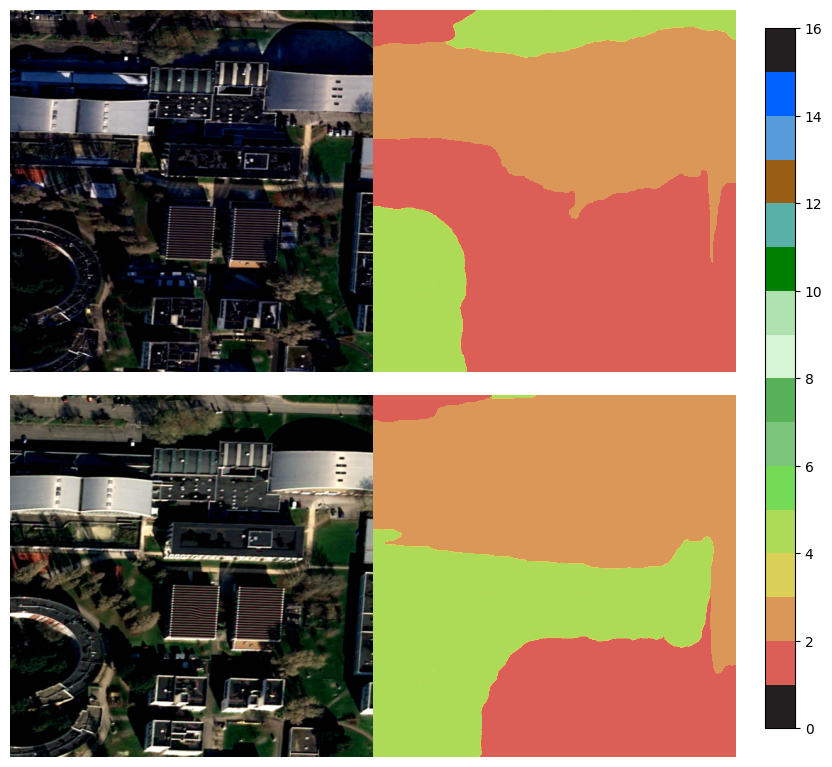

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(sample[0].permute(1, 2, 0))
image_bar = axs[0, 1].imshow(mask_pred0[0].to('cpu'), cmap, vmin=0, vmax=16)

axs[1, 0].imshow(sample[1].permute(1, 2, 0))
axs[1, 1].imshow(mask_pred1[0].to('cpu'), cmap, vmin=0, vmax=16)
for ax in axs.flat:
    ax.axis('off')

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # x, y, width, height (in figure coordinate)
fig.colorbar(image_bar, cax=cbar_ax)
# cbar = fig.colorbar(image_bar, ax=axs[:, 1], ticks = range(len(DFC2022.colormap)))
fig.subplots_adjust(hspace=0, wspace=0, right=0.85)
plt.show()
fig.savefig("X_compare.jpg")

In [ ]:
def visualize(model, img0 : str, img1 : str,  type : str='0.3m',):
    cmap = ListedColormap(DFC2022.colormap)
    preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                            reduce_labels=False,
                                            do_resize=False,
                                            do_rescale=False,
                                            do_normalize=False,)
    train_dataset, test_dataset = DFC2022Dataloader(preprocessor).get_dataset()
    # train_dataloader, test_dataloader = DFC2022Dataloader(preprocessor).get_dataloader(batch_size=4)
    # val_dataset, _ = DFC2022Dataloader(preprocessor, 'val').get_dataset()

    model = torch.load("Mask2_A_base_100.pt", map_location="cpu")

    if isinstance(model, torch.nn.DataParallel):
        model = model.module
        print("Loaded from dataparallel module.")
    if isinstance(model, dict):
        temp_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",)
        temp_model = torch.nn.DataParallel(temp_model)
        temp_model.load_state_dict(model)
        model = temp_model.module
        print("Loaded from dict.")

    scale_factor = 0.3 / 0.5
    new_width = int(img1.width * scale_factor)
    new_height = int(img1.height * scale_factor)
    
    resize_transform = T.Compose([
        T.Resize((new_height, new_width)),
        T.ToTensor()
    ])
    sample = K.AugmentationSequential(
                    K.RandomCrop((512, 512), p=1, keepdim=False),
                    # K.RandomVerticalFlip(),
                    # K.RandomHorizontalFlip(),
                    data_keys=['input', 'mask'],
                )(tensor_image0[:3].unsqueeze(0), tensor_image1[:3].unsqueeze(0))
    sample[0] = rearrange(sample[0], '() c h w -> c h w')
    sample[1] = rearrange(sample[1], '() c h w -> c h w')

    model.eval()
    with torch.no_grad():
        output0 = model(pixel_values=sample[0].to(device).unsqueeze(0))
        output1 = model(pixel_values=sample[1].to(device).unsqueeze(0))
    mask_pred0 = preprocessor.post_process_semantic_segmentation(output0,
                                                                target_sizes=[[512, 512]])
    mask_pred1 = preprocessor.post_process_semantic_segmentation(output1,
                                                                target_sizes=[[512, 512]])
    